<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
SVR for Regression 
</p>

In [3]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Modeling: SVR + pipeline + CV + metrics
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import PredefinedSplit, learning_curve
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error)

# Bayesian optimization utilities
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Utility
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')
warnings.filterwarnings("ignore", category=FutureWarning)

import time

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Load the same standardized dataset and folds
</p>

In [5]:
# Time-aware data load (from Data Preparation.ipynb outputs)

base_path = '../../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv", parse_dates=['time'])
df_test  = pd.read_csv(f"{base_path}/test.csv", parse_dates=['time'])
fold_assignments = np.load(f"{base_path}/train_folds.npy")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity',
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].to_numpy()
y_train = df_train['PL'].to_numpy()
X_test  = df_test[feature_names].to_numpy()
y_test  = df_test['PL'].to_numpy()

time_train = df_train['time'].to_numpy()
time_test  = df_test['time'].to_numpy()

ps = PredefinedSplit(fold_assignments)  # reuse the time-aware folds

print(f"Train: {len(df_train)} rows, Test: {len(df_test)} rows")
print(f"Train window: {df_train.time.min()} -> {df_train.time.max()}")
print(f"Test window:  {df_test.time.min()} -> {df_test.time.max()}")

Train: 1663627 rows, Test: 415907 rows
Train window: 2024-10-01 00:01:07.420593+00:00 -> 2025-08-12 17:18:53.293125+00:00
Test window:  2025-08-12 17:19:02.126782+00:00 -> 2025-09-30 23:59:55.971870+00:00


In [31]:
# use a fraction of the data (keeps time order) *per fold*. Set USE_SUBSET=False for full data.
USE_SUBSET = True
DATA_FRACTION = 0.1  # fraction of data to keep from each fold

if USE_SUBSET:
    fold_ids = np.unique(fold_assignments[fold_assignments != -1])
    keep_mask = np.zeros(len(df_train), dtype=bool)
    kept_counts = {}

    # keep the first DATA_FRACTION portion within each fold, preserving order
    for fid in fold_ids:
        idx = np.flatnonzero(fold_assignments == fid)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts[fid] = keep_n

    # (optional) if there are -1 labels in train, subset them too
    if np.any(fold_assignments == -1):
        idx = np.flatnonzero(fold_assignments == -1)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts['-1'] = keep_n

    df_train = df_train.iloc[keep_mask].copy()
    fold_assignments = fold_assignments[keep_mask]
    # subset test set separately if you still want a fraction
    n_test = max(1, int(np.ceil(len(df_test) * DATA_FRACTION)))
    df_test = df_test.iloc[:n_test].copy()

    print("Using subset per fold:", kept_counts)
    print(f"Train rows kept: {len(df_train)}, Test rows kept: {len(df_test)}")
else:
    print("Using full dataset")

if len(df_train) == 0 or len(df_test) == 0:
    raise ValueError("Subset produced empty data; increase DATA_FRACTION or disable USE_SUBSET.")

# refresh arrays/split objects
X_train = df_train[feature_names].to_numpy()
y_train = df_train["PL"].to_numpy()
X_test = df_test[feature_names].to_numpy()
y_test = df_test["PL"].to_numpy()
time_train = df_train["time"].to_numpy()
time_test = df_test["time"].to_numpy()
ps = PredefinedSplit(fold_assignments)

fold_ids = fold_assignments[fold_assignments != -1]
print("Unique CV fold labels:", np.unique(fold_ids), "count:", np.unique(fold_ids).size)
print("Counts per fold:", np.bincount(fold_ids) if fold_ids.size else "none")

Using subset per fold: {0: 55455, 1: 27728, 2: 27728, 3: 27728, 4: 27728}
Train rows kept: 166367, Test rows kept: 41591
Unique CV fold labels: [0 1 2 3 4] count: 5
Counts per fold: [55455 27728 27728 27728 27728]


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define SVR pipeline + search space
</p>

Why a pipeline? SVR is highly scale‑sensitive (C and ε depend on the target scale and feature magnitudes). We standardize features inside CV. I also let the search toggle the scaler (Standard vs Robust) to hedge against outliers.

In [32]:
def create_svr_pipeline():
    """
    (Scaler) -> SVR
    - Scaling is fitted only on train folds inside CV for proper evaluation.
    """
    return Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('svr', SVR(
            kernel='rbf',   # default; BayesSearchCV will tune kernel
            cache_size=1000 # MB; increase a bit to speed up training
        ))
    ])

# SVR hyperparameter search space (compact but expressive)
# Note: gamma is ignored for linear kernel; that's fine.
search_spaces = {
    'scaler': Categorical([
        StandardScaler(),
        RobustScaler(quantile_range=(10.0, 90.0))
    ]),
    'svr__kernel':  Categorical(['rbf', 'linear']),            # can add 'poly' if desired
    'svr__C':       Real(1e-2, 1e3, prior='log-uniform'),
    'svr__epsilon': Real(1e-3, 0.5, prior='log-uniform'),
    'svr__gamma':   Real(1e-5, 1e1, prior='log-uniform')       # used by 'rbf'
    # for polynomial kernel, we could add:
    # 'svr__degree': Integer(2, 4),
    # 'svr__coef0':  Real(0.0, 1.0)
}

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Bayesian optimization with PredefinedSplit + two metrics
</p>

In [ ]:
# ---- Multi-metric scoring (same as RF/KNN) ----
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---- PredefinedSplit ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization ----
bayes_cv_svr = BayesSearchCV(
    estimator=create_svr_pipeline(),
    search_spaces=search_spaces,
    n_iter=30,                               # adjust for runtime
    scoring=scoring,
    refit='neg_root_mean_squared_error',     # choose best by RMSE
    n_jobs=8,
    cv=ps,
    random_state=42,
    verbose=1,
    n_points=4,
    optimizer_kwargs={'n_initial_points': 12, 'acq_func': 'gp_hedge'}
)

print(f"Starting Bayesian optimization with {bayes_cv_svr.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold cross-validation per candidate...\n")

t0 = time.time()
bayes_cv_svr.fit(X_train, y_train)
t1 = time.time()
print(f"\nBayesian optimization complete in {(t1 - t0)/60:.2f} minutes.")

print("\nExtracting results...")


# Save best CV model right after fit
best_svr_model = bayes_cv_svr.best_estimator_
best_svr_params = bayes_cv_svr.best_params_
print("Best SVR Parameters Found:", best_svr_params)

os.makedirs('Results', exist_ok=True)
with open('Results/svr_best_cv_model.pkl', 'wb') as f:
    pickle.dump(best_svr_model, f)

print("Saved best CV model to Results/svr_best_cv_model.pkl")


# ---- Pull all tried configs/results into a dataframe ----
bayes_results_svr = pd.DataFrame(bayes_cv_svr.cv_results_).copy()
print(f"\nTried {bayes_results_svr.shape[0]} SVR configurations.")

# Save full CV results
cv_results_path = "Results/bayes_cv_results.csv"
bayes_results_svr.to_csv(cv_results_path, index=False)
print(f"\nSaved BayesSearchCV cv_results_ to: {cv_results_path}")

Starting Bayesian optimization with 30 iterations and 5-fold cross-validation per candidate...

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Bayesian optimization complete in 1243.65 minutes.

Extracting results...

Tried 30 SVR configurations.

Saved BayesSearchCV cv_results_ to: Results/bayes_cv_results.csv


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Summarize best CV results per kernel (for plotting & reporting)
</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bayes_results_svr = pd.read_csv("Results/bayes_cv_results.csv")

def fmt_value(v):
    # Treat estimator-looking strings as raw (no quotes), keep others as repr
    if isinstance(v, str) and "(" in v and v.endswith(")"):
        return v
    return repr(v)

def fmt_params(params):
    return "{" + ", ".join(f"'{k}': {fmt_value(v)}" for k, v in params.items()) + "}"

cv_summary_per_kernel = []
if 'param_svr__kernel' not in bayes_results_svr.columns:
    raise KeyError("BayesSearchCV results do not include 'param_svr__kernel'.")

for kernel in sorted(bayes_results_svr['param_svr__kernel'].dropna().astype(str).unique()):
    df_k = bayes_results_svr[bayes_results_svr['param_svr__kernel'].astype(str) == kernel]
    if not df_k.empty:
        idx = df_k['mean_test_neg_root_mean_squared_error'].idxmax()
        row = df_k.loc[idx]
        best_rmse = -row['mean_test_neg_root_mean_squared_error']
        std_rmse  =  row['std_test_neg_root_mean_squared_error']
        best_r2   =  row['mean_test_r2']
        std_r2    =  row['std_test_r2']
        best_params = {c.split('param_')[1]: row[c] for c in df_k.columns if c.startswith('param_')}

        print(f"Kernel={kernel:>6s} | Best CV RMSE: {best_rmse:.4f} | R²: {best_r2:.4f} | params: {fmt_params(best_params)}")

        cv_summary_per_kernel.append({
            'kernel': kernel,
            'best_cv_rmse': best_rmse,
            'std_cv_rmse': std_rmse,
            'best_cv_r2': best_r2,
            'std_cv_r2': std_r2,
            'best_params': best_params
        })

cv_svr_df = pd.DataFrame(cv_summary_per_kernel).sort_values('kernel').reset_index(drop=True)
summary_path = "Results/cv_summary_per_kernel.csv"
cv_svr_df.to_csv(summary_path, index=False)
print(f"Saved per-kernel CV summary to: {summary_path}")

Kernel=linear | Best CV RMSE: 10.1688 | R²: 0.7126 | params: {'scaler': RobustScaler(quantile_range=(10.0, 90.0)), 'svr__C': 0.01, 'svr__epsilon': 0.001, 'svr__gamma': 10.0, 'svr__kernel': 'linear'}
Kernel=   rbf | Best CV RMSE: 7.6823 | R²: 0.8283 | params: {'scaler': RobustScaler(quantile_range=(10.0, 90.0)), 'svr__C': 2.3785393231161978, 'svr__epsilon': 0.4999999999999999, 'svr__gamma': 0.0245654190114079, 'svr__kernel': 'rbf'}
Saved per-kernel CV summary to: Results/cv_summary_per_kernel.csv


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plot: best CV RMSE and its STD vs the Cost 
</p>

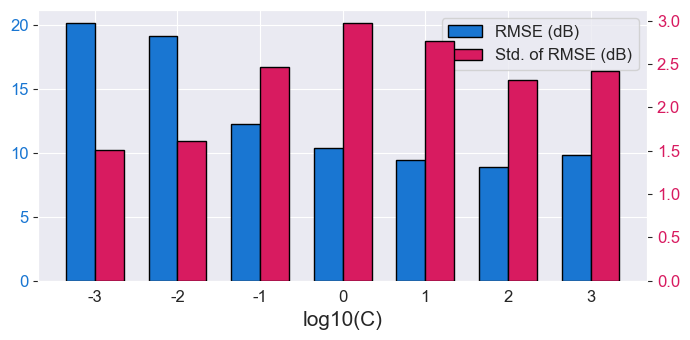

In [ ]:
# Load sweep results
sweep_df = pd.read_csv("Results/svr_c_sweep_cv.csv")

# If log10_C wasn't saved, compute it
if "log10_C" not in sweep_df.columns:
    sweep_df["log10_C"] = np.log10(sweep_df["C"].astype(float))

# ---- plot styling ----
tick_fontsize = 12
axis_labelsize = 15
legend_fontsize = 12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
sns.set_style("darkgrid")

# --- RMSE + STD (twin axes) ---
x = np.arange(len(sweep_df))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

bars1 = ax1.bar(
    x - bar_width/2,
    sweep_df['rmse_mean'],
    bar_width,
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
ax1.set_xlabel('log10(C)', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels([f"{v:.0f}" for v in sweep_df['log10_C']], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2,
    sweep_df['rmse_std'],
    bar_width,
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/SVR_RMSE_STD_vs_log10C.png',
            dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plot: best CV R² and its STD per cpst C
</p>

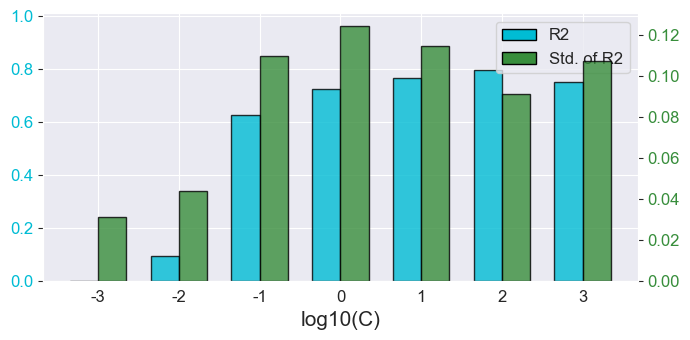

In [43]:
# --- R2 + STD (twin axes) ---
fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Cyan bars: R2 (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2,
    sweep_df['r2_mean'],
    bar_width,
    color='#00bcd4',
    label='R2',
    edgecolor='black',
    linewidth=1,
    alpha=0.8
)
ax1.set_xlabel('log10(C)', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels([f"{v:.0f}" for v in sweep_df['log10_C']], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# Green bars: STD of R2 (right y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2,
    sweep_df['r2_std'],
    bar_width,
    color='#388e3c',
    label='Std. of R2',
    edgecolor='black',
    linewidth=1,
    alpha=0.8
)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R2'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R2')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/SVR_R2_STD_vs_log10C.png',
            dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Evaluate best SVR on train/test; save model 
</p>

In [6]:
# Load best CV model (saved after BayesSearchCV fit)
model_path = "Results/svr_best_cv_model.pkl"

if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        best_svr_model = pickle.load(f)
    print(f"Loaded best CV model from: {model_path}")
elif "bayes_cv_svr" in globals() and hasattr(bayes_cv_svr, "best_estimator_"):
    best_svr_model = bayes_cv_svr.best_estimator_
    print("\nUsing best SVR model from BayesSearchCV (refit on full train data)...")
else:
    raise FileNotFoundError(
        "Best SVR model not found. Run BayesSearchCV or load the saved model."
    )

if "bayes_cv_svr" in globals() and hasattr(bayes_cv_svr, "best_params_"):
    best_svr_params = bayes_cv_svr.best_params_
else:
    svr_step = best_svr_model.named_steps["svr"]
    best_svr_params = {
        "scaler": best_svr_model.named_steps["scaler"],
        "svr__C": svr_step.C,
        "svr__epsilon": svr_step.epsilon,
        "svr__gamma": getattr(svr_step, "gamma", None),
        "svr__kernel": svr_step.kernel,
    }
print("Best SVR Parameters Found:", best_svr_params)

y_train_pred = best_svr_model.predict(X_train)
y_test_pred  = best_svr_model.predict(X_test)

train_mse   = mean_squared_error(y_train, y_train_pred)
test_mse    = mean_squared_error(y_test, y_test_pred)
train_r2    = r2_score(y_train, y_train_pred)
test_r2     = r2_score(y_test, y_test_pred)
test_rmse   = np.sqrt(test_mse)
test_mape   = mean_absolute_percentage_error(y_test, y_test_pred)
test_med_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_med_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

# Ensure the directory exists (align to RF/KNN saving pattern)
os.makedirs('../Models', exist_ok=True)

# Save the trained SVR model
with open('../Models/svr_final_model.pkl', 'wb') as f:
    pickle.dump(best_svr_model, f)

print("Trained SVR model saved to ../Models/svr_final_model.pkl")

Loaded best CV model from: Results/svr_best_cv_model.pkl
Best SVR Parameters Found: {'scaler': RobustScaler(quantile_range=(10.0, 90.0)), 'svr__C': 2.3785393231161978, 'svr__epsilon': 0.49999999999999994, 'svr__gamma': 0.024565419011407994, 'svr__kernel': 'rbf'}

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),42.676874
1,Test Loss (MSE),45.498267
2,Test RMSE,6.745240
3,R² Score (Train),0.879454
4,R² Score (Test),0.871658
5,Test MAPE (%),5.059409
6,Test Median AE,3.347075


Trained SVR model saved to ../Models/svr_final_model.pkl


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Diagnostics: learning curve, residuals, physics, predicted vs. real (saved)
</p>

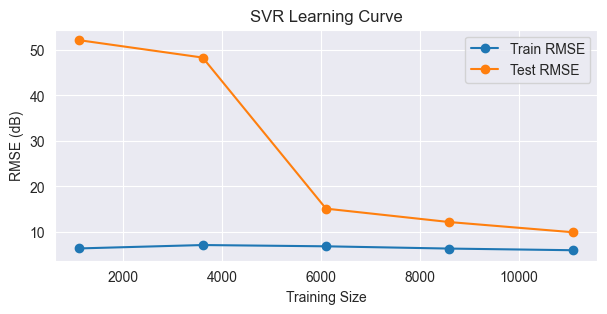

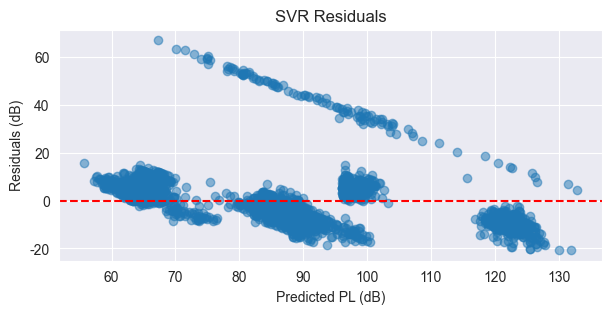

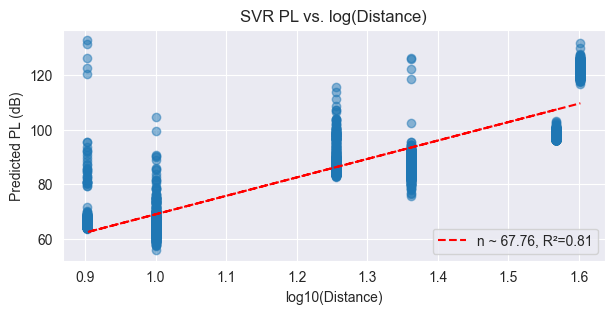

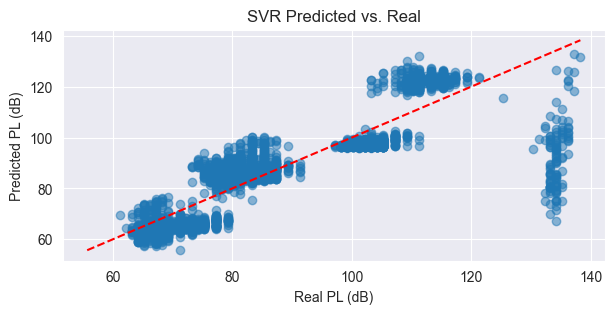

In [ ]:
svr_model = best_svr_model  # alias

figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# 1. Learning Curve (neg RMSE)
train_sizes, train_scores, test_scores = learning_curve(
    svr_model, X_train, y_train,
    cv=ps, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='neg_root_mean_squared_error'
)
train_rmse = -train_scores.mean(1)
test_rmse  = -test_scores.mean(1)

plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse,  'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('SVR Learning Curve')
plt.legend()
plt.savefig(f'{path}SVR_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Residuals
y_test_pred = svr_model.predict(X_test)
residuals   = y_test - y_test_pred
plt.figure(figsize=figsize)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('SVR Residuals')
plt.savefig(f'{path}SVR_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Physics Consistency (PL vs. log(distance))
dist     = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)
slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
plt.figure(figsize=figsize)
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--',
         label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('SVR PL vs. log(Distance)')
plt.legend()
plt.savefig(f'{path}SVR_physics_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Predicted vs. Real
plt.figure(figsize=figsize)
lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot(lims, lims, 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('SVR Predicted vs. Real')
plt.savefig(f'{path}SVR_pred_vs_real.png', dpi=300, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
SVR model complexity diagnostic
</p>

In [ ]:
# For SVR, the number of support vectors indicates model complexity.
# Note: attribute exists after fitting; % of SVs close to 100% often signals overfitting.
try:
    n_sv = best_svr_model.named_steps['svr'].support_.shape[0]
    frac_sv = n_sv / X_train.shape[0]
    print(f"Support vectors: {n_sv} ({frac_sv:.2%} of training samples)")
except Exception as e:
    print("Could not compute support vector count:", e)


Support vectors: 16627 (99.93% of training samples)
